In [719]:
import json
import torch
import sklearn
import sklearn.preprocessing
import numpy as np
arr = np.asarray

To simplify the task, I am training only on forkhead proteins, a homologous family of proteins with high biological relevance in neurodevelopment and immunity.

In [5]:
f = open('9606_database.json')
dicts = {}
for line in f.readlines():
    d = json.loads(line)
    name = d['ACC_entry']
    dicts[name] = d
    
forkhead_dict = {}
for key in dicts.keys():
    protname = key.lower()
    if 'fox' in protname:
        forkhead_dict[key] = dicts[key]

Text(0.5, 1.0, 'Sequence length of forkhead proteins in database')

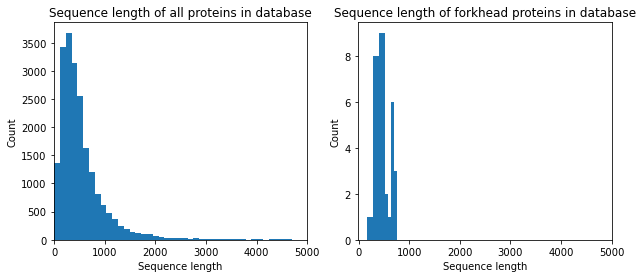

In [678]:
import matplotlib.pyplot as plt
lengths = []
for key in dicts:
    length = len(dicts[key]['seq'])
    lengths.append(length)
fig, axs = plt.subplots(1, 2, figsize=(10, 4)); axs = np.ravel(axs)
ax = axs[0]
_ = ax.hist(lengths, bins=300)
ax.set_xlim([-10, 5000])
ax.set_xlabel("Sequence length")
ax.set_ylabel("Count")
ax.set_title("Sequence length of all proteins in database")

lengths = []
for key in forkhead_dict:
    length = len(forkhead_dict[key]['seq'])
    lengths.append(length)
ax = axs[1]
_ = ax.hist(lengths, bins=10)
ax.set_xlim([-10, 5000])
ax.set_xlabel("Sequence length")
ax.set_ylabel("Count")
ax.set_title("Sequence length of forkhead proteins in database")

In [7]:
padding_token = "_p"
masking_token = "m"
masking_index = 23

all_aas = set()
for key in dicts:
    for i in dicts[key]['seq']:
        all_aas.add(i)
        
# AAs, mask, padding token
aa_list = list(all_aas) + [padding_token] + [masking_token]
le = sklearn.preprocessing.LabelEncoder()
le.fit(aa_list)

n_tokens = len(aa_list); 
n_proteins = len(dicts);
masking_index = le.transform([masking_token])
padding_index = le.transform([padding_token])

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# Goal

I was curious to see if MLM would learn faster if masking was performed preferentially over conserved residues rather than uniformly at random. If many residues in a protein are not conserved, then training data where the masking contains non-conserved residues may be uninformative, since the model may mostly be attempting to predict noise. Notably, this may be a much larger problem in proteins than NLP, since most words in a sentence are typically informative in NLP; this may not be true in proteins.


#### Examining conservation scores in forkhead proteins

In [710]:
cutoff = 2
fkh_means = []
fkh_stds = []
fkh_frac_below_cutoff = []
for key, v in forkhead_dict.items():
    conservation_seq = forkhead_dict[key][conservation_key]
    vec = conservation2num(conservation_seq).numpy()
    fkh_stds.append(np.std(vec))
    fkh_means.append(np.mean(vec))
    fkh_frac_below_cutoff.append(np.mean(vec < cutoff))
    
all_means = []
all_stds = []
all_frac_below_cutoff = []
for key, v in dicts.items():
    conservation_seq = dicts[key][conservation_key]
    if conservation_seq == "NULL":
        continue
    vec = conservation2num(conservation_seq).numpy()
    all_stds.append(np.std(vec))
    all_means.append(np.mean(vec))
    all_frac_below_cutoff.append(np.mean(vec < cutoff))

We see that there is a wide range of conservation scores across proteins. Interestingly, forkhead proteins are not especially conserved relative to other proteins, suggesting that they are a relatively representative sample for the purposes of this test.

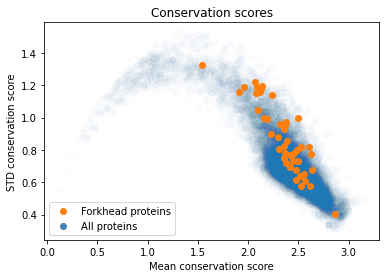

In [705]:
fig, ax = plt.subplots()
ax.scatter(all_means, all_stds, alpha=.01)
ax.scatter(fkh_means, fkh_stds, label='Forkhead proteins')
ax.scatter([], [], color='steelblue', label='All proteins')
ax.set_title("Conservation scores")
ax.set_xlabel("Mean conservation score for protein")
ax.set_ylabel("STD conservation score for protein")
ax.legend()

As many as 40% of residues have a conservation score < 2: this suggests that many training examples may not be particularly informative.

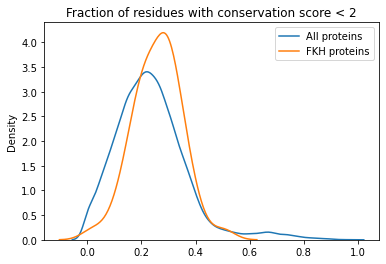

In [718]:
fig, ax = plt.subplots()
sns.kdeplot(all_frac_below_cutoff, label='All proteins', ax=ax)
sns.kdeplot(fkh_frac_below_cutoff, label='FKH proteins', ax=ax)
ax.set_title(f"Fraction of residues with conservation score < {cutoff}")
ax.legend()

To examine whether preferentially masking conserved residues helps, I made four different models. One is uniformly at random, the other three are weighted (with different weights) mask conserved residues more frequently. All four have identical mean mutation rates over all residues.

In [635]:
#### from importlib import reload
from dataloaders import *
from masking_functions import *
from model import *
from aux_functions import *
from torch.utils.data import random_split

conservation_key = 'MMseq2_conservation_score'
d_hid = 80  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 20  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 10 # number of heads in nn.MultiheadAttention
dropout = 0.1  # dropout probability 
emsize = nhead*10 # embedding dimension
mutprob = .1
criterion = nn.CrossEntropyLoss()

# Making four different models with separate the parameters 
# 'b' refers to beta parameter: higher 'b' means conserved residues 
# are masked more frequently
masking_function_dict = {
    f'random_mutprob={mutprob}_b=1' : (mutate_at_random, mutprob, 1),
    f'weighted_mutprob={mutprob}_b=.5' : (mutate_with_conservation_score, mutprob, .5),
    f'weighted_mutprob={mutprob}_b=1' : (mutate_with_conservation_score, mutprob, 1),
    f'weighted_mutprob={mutprob}_b=2' : (mutate_with_conservation_score, mutprob, 2),
}

train_data_dict = {}
val_data_dict = {}
model_dict = {}
for cond, parameters in masking_function_dict.items():
    (masking_function, mut_prob, beta) = parameters
    # Make datasets using the different masking functions
    # We train on crops of 64 for each protein
    # So we select 50 different crops from each protein to augment the data set
    train_dataloader, val_dataloader = make_train_test(masking_function, forkhead_dict, n_tokens, le, 
                                                       conservation_key, padding_index, masking_index, 
                                                       mut_prob, device, n_crop_per_protein=50, beta=beta,
                                                      train_val_split = [.8, .2])

    model, optimizer, scheduler = make_model(d_hid, nlayers, nhead, dropout, emsize, device, n_tokens)
    train_data_dict[cond] = train_dataloader
    val_data_dict[cond] = val_dataloader
    model_dict[cond] = (model, optimizer, scheduler)

1920
d_model: 100
1920
d_model: 100
1920
d_model: 100
1920
d_model: 100


I was testing my model by looking at how long it took the model to memorize small datasets (10-20 protein crops). This was taking very many epochs, so I was concerned that if the model were trained for too short time it would be severely underfit. Because of this I decided to train for a really long time. As you can see below, it ended up overfitting.

In [672]:
from importlib import reload

from dataloaders import *
from masking_functions import *
from model import *
from aux_functions import *
from torch.utils.data import random_split

import pandas as pd
train_loss_df = pd.DataFrame()
val_loss_df = pd.DataFrame()
for cond, model_tuple in model_dict.items():
    tmp_train_losses = []
    val_loss_dict = {}
    train_dataloader = train_data_dict[cond]
    print("Starting training of", cond)

    (model, optimizer, scheduler) = model_tuple
    train_and_validate(model, train_dataloader, val_data_dict, 
                                                     optimizer, scheduler, criterion, tmp_train_losses, val_loss_dict, epochs=500)
    print("Done with", cond)
    train_loss_df[cond] = tmp_train_losses
    for loss_cond, loss in val_loss_dict.items():
        val_loss_df[f'{cond}|{loss_cond}'] = loss

SyntaxError: invalid syntax (2110458129.py, line 8)

In [396]:
def get_label(col):
    return col.split("_")[0] + "_" + col.split("_")[-1]

Overfitting of the model is seen below

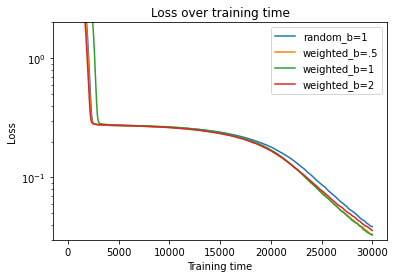

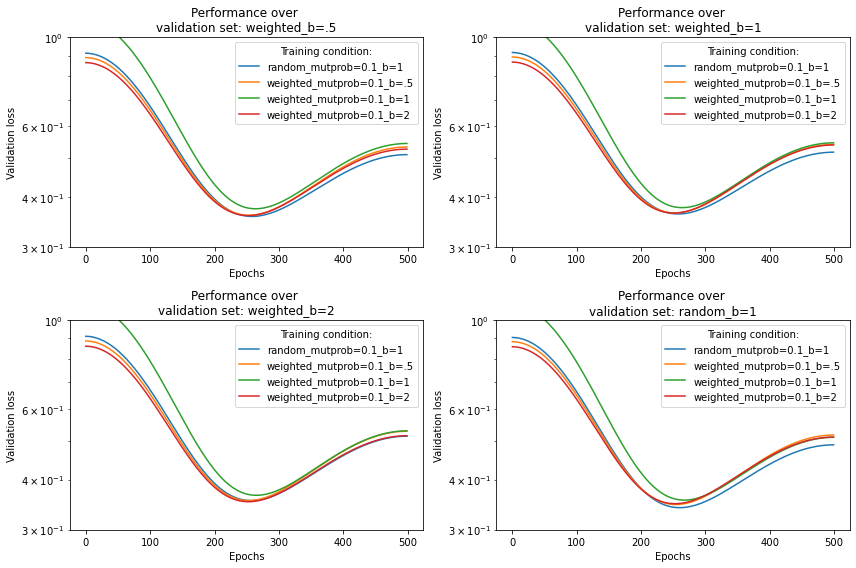

In [659]:
import scipy; import scipy.ndimage
fig, ax = plt.subplots()
for col in train_loss_df:
    label = get_label(col)
    v = train_loss_df[col]+1e-5
    smoothv = scipy.ndimage.gaussian_filter1d(v, sigma=100)
    ax.plot(smoothv, label=label)
ax.legend()
ax.set_title("Loss over training time")
ax.set_xlabel("Training time")
ax.set_ylabel("Loss")
ax.set_ylim([3e-2, 2])
ax.set_yscale('log')
validation_conditions = set([x.split("|")[-1] for x in val_loss_df.columns])
fig, axs = plt.subplots(2, 2, figsize=(12, 8)); axs = axs.flatten()
for c, validation_condition_oi in enumerate(validation_conditions):
    ax = axs[c]
    for col in val_loss_df:
        training_condition, validation_condition = col.split("|")
        if validation_condition_oi == validation_condition:
            validation_losses = val_loss_df[col]
            training_label = get_label(col)

            v = validation_losses+1e-5
            smoothv = scipy.ndimage.gaussian_filter1d(v, sigma=100)
            ax.plot(smoothv, label=training_condition)

    label = get_label(validation_condition_oi)
    ax.set_title(f'Performance over \nvalidation set: {label}')
    legax = ax.legend(bbox_to_anchor=(1, 1))
    legax.set_title("Training condition:")
    ax.set_ylabel("Validation loss")
    ax.set_xlabel("Epochs")
    ax.set_ylim([3e-1, 1])
    ax.set_yscale('log')
plt.tight_layout()

### Visualize Confidence of the Model

To visualize confidence, I take the maximum probability over the predicted AAs for masked positions. For example, if the model predicts one AA with p=1 over a masked position, the confidence score is equal to 1. If it predicts two AA with .6, and .4, the confidence score is .6.

#### Confidence of model over training data

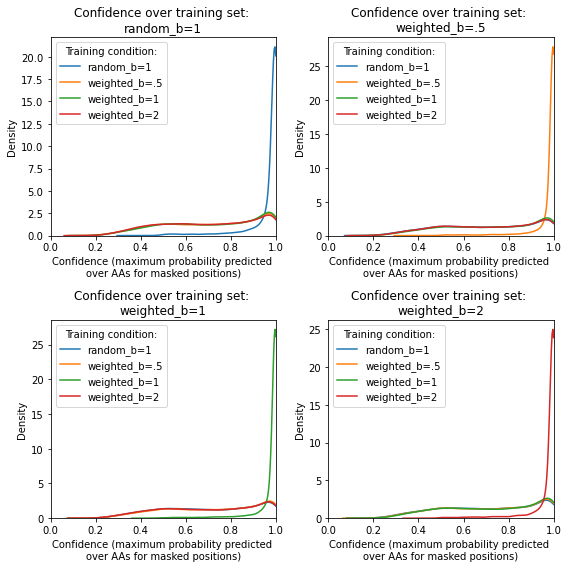

In [667]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8)); axs = np.ravel(axs)
for c, (val_condition, train_data) in enumerate(train_data_dict.items()):
    ax = axs[c]
    for cond, model_params in model_dict.items():
        model = model_params[0]
        all_values = []
        for batch, data in enumerate(train_data):
            inputdata, target, masked = data['input'], data['output'], data['mask']
            output = model(inputdata, masked)

            sm_output = torch.nn.functional.softmax(output, dim=2)
            masked_outputs = (target-inputdata != 0).sum(axis=2)> 0
            max_values = torch.amax(sm_output, axis=2)
            max_values_along_masked_outputs = max_values[masked_outputs]
            all_values += list((max_values_along_masked_outputs.cpu().detach().numpy()))
        sns.kdeplot(all_values, label=get_label(cond), clip = (0.0, 1.0), ax=ax)
    legax = ax.legend(loc = 'upper left')
    legax.set_title("Training condition:")
    ax.set_title(f'Confidence over training set: \n{get_label(val_condition)}')
    ax.set_xlabel('Confidence (maximum probability predicted \nover AAs for masked positions)')
    ax.set_ylabel('Density')
    ax.set_xlim([0, 1])
plt.tight_layout()

#### Confidence of Model over Validation Data

We see that all of the models are similarly confident on the validation data, this may be due to overfitting. 

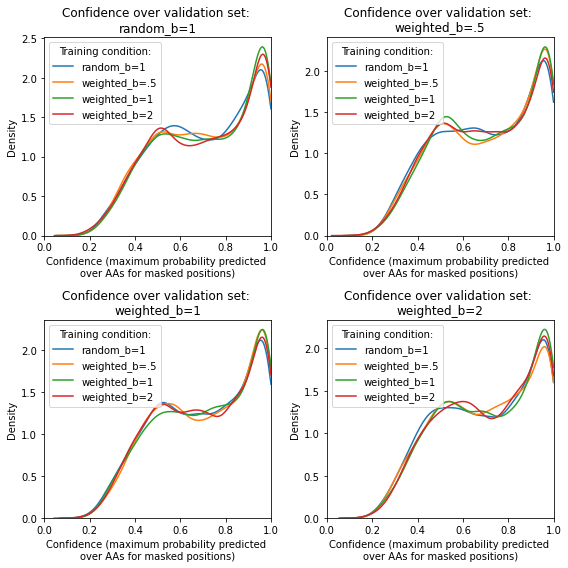

In [666]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8)); axs = np.ravel(axs)
for c, (val_condition, val_dataloader) in enumerate(val_data_dict.items()):
    ax = axs[c]
    for cond, model_params in model_dict.items():
        model = model_params[0]
        all_values = []
        for batch, data in enumerate(val_dataloader):
            inputdata, target, masked = data['input'], data['output'], data['mask']
            output = model(inputdata, masked)

            sm_output = torch.nn.functional.softmax(output, dim=2)
            masked_outputs = (target-inputdata != 0).sum(axis=2)> 0
            max_values = torch.amax(sm_output, axis=2)
            max_values_along_masked_outputs = max_values[masked_outputs]
            all_values += list((max_values_along_masked_outputs.cpu().detach().numpy()))
        sns.kdeplot(all_values, label=get_label(cond), clip = (0.0, 1.0), ax=ax)
    legax = ax.legend(loc = 'upper left')
    legax.set_title("Training condition:")
    ax.set_title(f'Confidence over validation set: \n{get_label(val_condition)}')
    ax.set_xlabel('Confidence (maximum probability predicted \nover AAs for masked positions)')
    ax.set_ylabel('Density')
    ax.set_xlim([0, 1])
plt.tight_layout()

#### Example outputs


Some example output from the last run of the model, first on training data

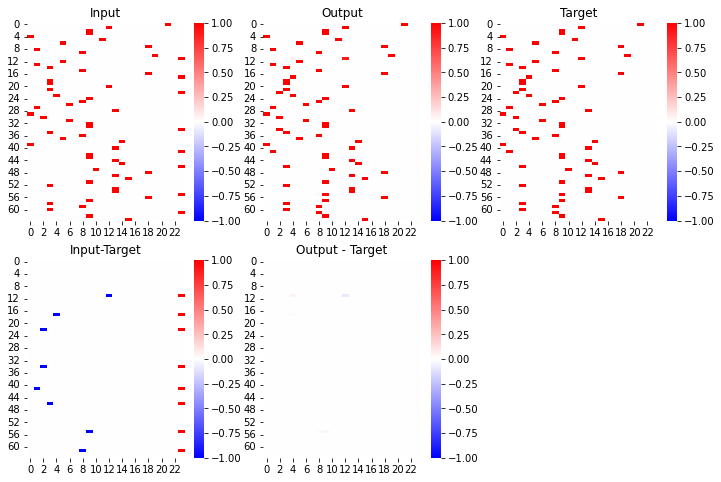

In [668]:
import seaborn as sns
val_dataloader = train_data_dict[cond]
for batch, data in enumerate(val_dataloader):
    inputdata, target, masked = data['input'], data['output'], data['mask']
    output = model(inputdata, masked)

ind = 0
sm_output = torch.nn.functional.softmax(output[ind], dim=1)
fig, axs = plt.subplots(2, 3, figsize=(12, 8)); axs = np.ravel(axs);
ax = axs[0]; sns.heatmap((inputdata).cpu().detach().numpy()[ind], cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_title("Input")

ax = axs[1]; sns.heatmap(sm_output.cpu().detach().numpy(), cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_title("Output")

ax = axs[2]; sns.heatmap((target).cpu().detach().numpy()[ind], cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_title("Target")

ax = axs[3]; sns.heatmap((inputdata-target).cpu().detach().numpy()[ind], cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_title("Input-Target")

ax = axs[4]; sns.heatmap((sm_output-target).cpu().detach().numpy()[ind], cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_title("Output - Target")
axs[5].remove()

Some example output from the last run of the model, now on testing data

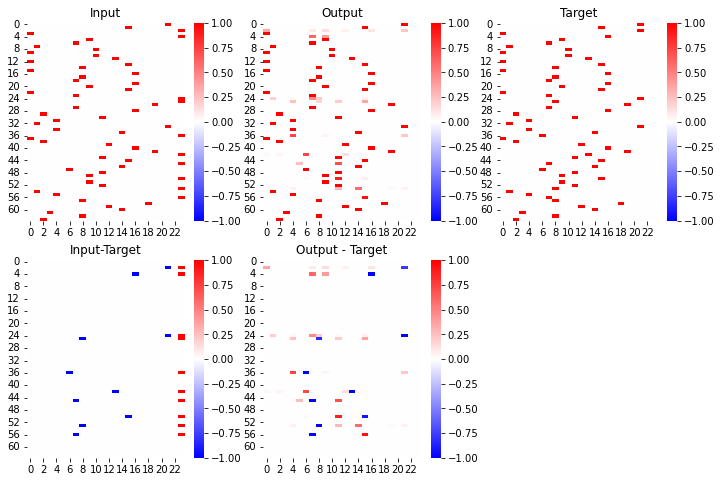

In [669]:
import seaborn as sns
val_dataloader = val_data_dict[cond]
for batch, data in enumerate(val_dataloader):
    inputdata, target, masked = data['input'], data['output'], data['mask']
    output = model(inputdata, masked)

ind = 0
sm_output = torch.nn.functional.softmax(output[ind], dim=1)
fig, axs = plt.subplots(2, 3, figsize=(12, 8)); axs = np.ravel(axs);
ax = axs[0]; sns.heatmap((inputdata).cpu().detach().numpy()[ind], cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_title("Input")

ax = axs[1]; sns.heatmap(sm_output.cpu().detach().numpy(), cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_title("Output")

ax = axs[2]; sns.heatmap((target).cpu().detach().numpy()[ind], cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_title("Target")

ax = axs[3]; sns.heatmap((inputdata-target).cpu().detach().numpy()[ind], cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_title("Input-Target")

ax = axs[4]; sns.heatmap((sm_output-target).cpu().detach().numpy()[ind], cmap='bwr', vmin=-1, vmax=1, ax=ax)
ax.set_title("Output - Target")
axs[5].remove()

# Next steps

For next steps, I would change several things:

(a) Save the model with the lowest validation score. For some reason I overlooked this, which was a significant oversight.

(b) Train on larger dataset. Since we're only training on a small subset of forkhead proteins, it may not be so difficult to learn the conserved motifs. Masking conserved sites may help more when training on a diverse proteins. Alternatively, a more useful strategy may be to select the protein crops based on conservation score, rather than modifying the masking mechanism.

(c) Examine the embeddings of these forkhead proteins to confirm the validity of the language model. There is a rich biology and classification of Forkhead proteins, and it would be interesting to examine whether this language model captures these classifications by embedding the latent vectors of the model.